<div class="alert alert-block alert-info">
    <h1>Análisis de Series Temporales</h1>
    <h3>Modelo LSTM</h3>
    <h3>
</div>

**Carga de Librerías**

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from scipy.stats import pearsonr
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_absolute_error, mean_squared_error
from scipy.stats import jarque_bera, shapiro, boxcox, probplot
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.stats.diagnostic import acorr_ljungbox, acorr_breusch_godfrey
from sklearn.metrics import mean_squared_error
import math
from statistics import mean
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import RMSprop
import tensorflow as tf

**Carga de datos**

In [2]:
# Lee el archivo Excel en un DataFrame de pandas
data = pd.read_excel("C:/Users/German/OneDrive - Universidad Nacional de San Martin/Documentos/PROYECTOS/UA-MAESTRIA/14_Análisis_de_Series_Temporales/TP2/ST_ATENCION2.xlsx")
# Ahora puedes trabajar con los datos en el DataFrame
print(data.head())

       FECHA  WAPP  TP  TAD  PP
0 2022-03-15    19  78   53   9
1 2022-03-16    12  70   26  12
2 2022-03-17    14  66   41  14
3 2022-03-18    67  50   20   9
4 2022-03-21    45  65   44   8


# Procesamiento de datos

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 380 entries, 0 to 379
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   FECHA   380 non-null    datetime64[ns]
 1   WAPP    380 non-null    int64         
 2   TP      380 non-null    int64         
 3   TAD     380 non-null    int64         
 4   PP      380 non-null    int64         
dtypes: datetime64[ns](1), int64(4)
memory usage: 15.0 KB


En los siguientes pasos:  
-Convertimos la columna FECHA al formato datetime  
-Fijamos esta columna datetime como el nuevo índice de nuestro DataFrame      
-Orden cronológico ascendente

In [4]:
data['FECHA'].dtype #otra forma de verificar

dtype('<M8[ns]')

In [5]:
data['FECHA'] = pd.to_datetime(
    data['FECHA'],
    format = '%Y.%m.%d'
)

In [6]:
data = data.set_index('FECHA')

In [7]:
data.sort_index(inplace=True)

In [8]:
data.head(3)

,WAPP,TP,TAD,PP
FECHA,,,,
2022-03-15,19,78,53,9
2022-03-16,12,70,26,12
2022-03-17,14,66,41,14


**Análisis de datos faltantes**

In [10]:
print('Cantidad de NaNs:')
for column in data:
    nans = data[column].isna().sum()
    print(f'\tColumna {column}: {nans}')

Cantidad de NaNs:
	Columna WAPP: 0
	Columna TP: 0
	Columna TAD: 0
	Columna PP: 0


# Modelo univariado-WAPP


A la entrada del modelo introduciremos una única variable, mientras que a la salida también tendremos una única variable e intentaremos predecir 15 días a futuro.

**División de los datos: Sets de entrenamiento, validación y prueba**  

A diferencia de otros modelos de Machine Learning, en el caso de series de tiempo y las Redes LSTM se debe garantizar que se generan las particiones sin mezclar aleatoriamente los datos.

In [11]:
def train_val_test_split(serie, tr_size=0.8, vl_size=0.1, ts_size=0.1 ):
    # Definir número de datos en cada subserie
    N = serie.shape[0]
    Ntrain = int(tr_size*N)  # Número de datos de entrenamiento
    Nval = int(vl_size*N)    # Número de datos de validación
    Ntst = N - Ntrain - Nval # Número de datos de prueba

    # Realizar partición
    train = serie[0:Ntrain]
    val = serie[Ntrain:Ntrain+Nval]
    test = serie[Ntrain+Nval:]

    return train, val, test

In [12]:
tr, vl, ts = train_val_test_split(data['TAD'])

# Imprimir en pantalla el tamaño de cada subset
print(f'Tamaño set de entrenamiento: {tr.shape}')
print(f'Tamaño set de validación: {vl.shape}')
print(f'Tamaño set de prueba: {ts.shape}')

Tamaño set de entrenamiento: (304,)
Tamaño set de validación: (38,)
Tamaño set de prueba: (38,)


**Ploteamos cómo quedarían separados los datos:**

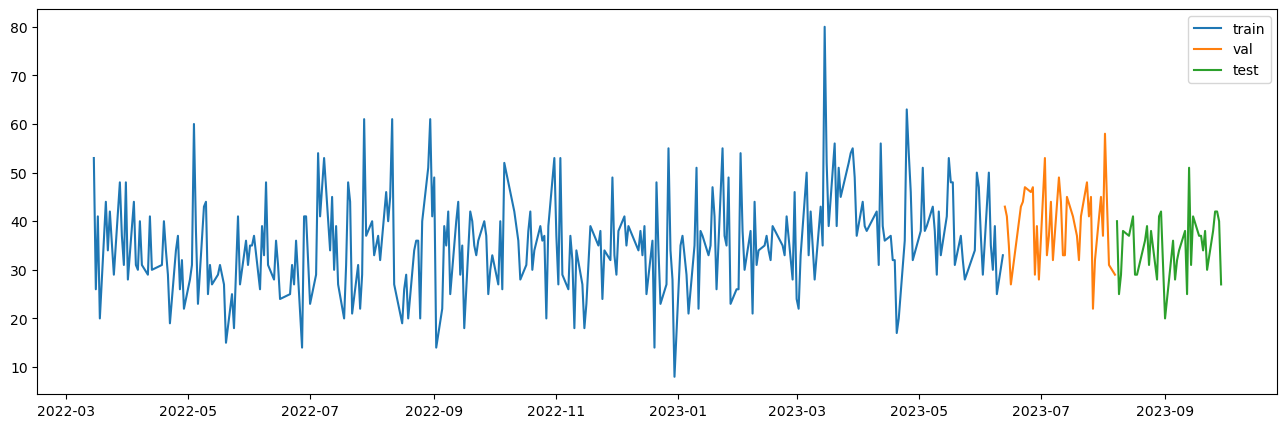

In [13]:
fig, ax = plt.subplots(figsize=(16,5))
ax.plot(tr,label="train")
ax.plot(vl,label="val")
ax.plot(ts,label="test")
plt.legend();

**Adecuación para una red LSTM: Dataset supervisado**

Ajustaremos nuestros sets de entrenamiento, validación y prueba al formato requerido por la Red LSTM para realizar el entrenamiento y posteriormente calcularemos las predicciones.  
Para este modelo, puntualmente ingresaremos al mismo registros continuos de 100 días para la variable WAPP y el modelo deberá aprender a predecir 76 días a futuro  
Debemos estructurar nuestros sets de la siguiente manera:  
*Entrada (X):* arreglo de tamaño batches x input_length x features  
*Salida (Y):* arreglo de tamaño batches x output_length x features

donde:

**batches** es el número total de datos de entrada y de salida. Por ejemplo, el set de entrenamiento tiene un total de 304 datos pero estos deberán ser divididos en bloques consecutivos de 13 registros (10  + 3 de salida). Cada uno de estos bloques será un dato de entrenamiento y los batches serán simplemente el número total de bloques.  
**input_length** es el número de registros consecutivos que usaremos a la entrada del modelo. En nuestro caso este valor es igual a 10 y esto se convertirá en un hiperparámetro del modelo que se podrá modificar y que impactará el desempeño del modelo obtenido.  
**features** es simplemente el número de variables de entrada o de salida que usaremos. Como estamos usando un enfoque univariado y a la salida haremos la predicción únicamente de la variable seleccionada, en ambos casos tendremos features = 1  
**output_length** es el número de bloques a futuro que queremos predecir con el modelo. En este caso tendremos output_length = 3

Teniendo en cuenta lo anterior, podemos concluir que cada subset (entrenamiento, validación y prueba) deberá ser pre-procesado para obtener los arreglos X (entradas) y Y (salidas) los cuales tendrán estos tamaños:  

X: batches x 10 x 1  
Y: batches x 3 x 1  

Creamos la función para el procesamiento necesario

In [14]:
def crear_dataset_supervisado(array, input_length, output_length):

    # Inicialización
    X, Y = [], []    # Listados que contendrán los datos de entrada y salida del modelo
    shape = array.shape
    if len(shape)==1: # Si tenemos sólo una serie (univariado)
        fils, cols = array.shape[0], 1
        array = array.reshape(fils,cols)
    else: # Multivariado
        fils, cols = array.shape

    # Generar los arreglos (utilizando ventanas deslizantes de longitud input_length)
    for i in range(fils-input_length-output_length):
        X.append(array[i:i+INPUT_LENGTH,0:cols])
        Y.append(array[i+input_length:i+input_length+output_length,-1].reshape(output_length,1))

    # Convertir listas a arreglos de NumPy
    X = np.array(X)
    Y = np.array(Y)

    return X, Y

In [15]:
# Definición de los hiperparámetros INPUT_LENGTH y OUTPUT_LENGTH
INPUT_LENGTH = 10    # Registros de bloques consecutivos a la entrada
OUTPUT_LENGTH = 3    # El modelo va a predecir 76 días a futuro
# Datasets supervisados para entrenamiento (x_tr, y_tr), validación
# (x_vl, y_vl) y prueba (x_ts, y_ts)
x_tr, y_tr = crear_dataset_supervisado(tr.values, INPUT_LENGTH, OUTPUT_LENGTH)
x_vl, y_vl = crear_dataset_supervisado(vl.values, INPUT_LENGTH, OUTPUT_LENGTH)
x_ts, y_ts = crear_dataset_supervisado(ts.values, INPUT_LENGTH, OUTPUT_LENGTH)

Visualizamos el tamaño de los arreglos generados:

In [16]:
print('Tamaños entrada (BATCHES x INPUT_LENGTH x FEATURES) y de salida (BATCHES x OUTPUT_LENGTH x FEATURES)')
print(f'Set de entrenamiento - x_tr: {x_tr.shape}, y_tr: {y_tr.shape}')
print(f'Set de validación - x_vl: {x_vl.shape}, y_vl: {y_vl.shape}')
print(f'Set de prueba - x_ts: {x_ts.shape}, y_ts: {y_ts.shape}')

Tamaños entrada (BATCHES x INPUT_LENGTH x FEATURES) y de salida (BATCHES x OUTPUT_LENGTH x FEATURES)
Set de entrenamiento - x_tr: (291, 10, 1), y_tr: (291, 3, 1)
Set de validación - x_vl: (25, 10, 1), y_vl: (25, 3, 1)
Set de prueba - x_ts: (25, 10, 1), y_ts: (25, 3, 1)


Cada dato de entrenamiento, validación y prueba tendrá un tamaño de 10x1 (INPUT_LENGTH x FEATURES) para la entrada y de 3x1 (OUTPUT_LENGTH x FEATURES) para la salida.

**Escalamiento de los datos**

Es recomendable, al utilizar modelos de deep learning, asegurar que las variables que alimentan el modelo se encuentran en el mismo rango de valores. (Mejora el algoritmo de predicción y por lo tanto las predicciones)

Lo anterior implica que la Red LSTM será entrenada con valores escalados. Recordar que, una vez entrenado el modelo y al momento de generar las predicciones, tendremos que realizar un escalamiento inverso, llevando las predicciones del rango de -1 a 1 al rango normal de temperaturas.

In [17]:
def escalar_dataset(data_input):
    NFEATS = data_input['x_tr'].shape[2]

    # Generar listado con "scalers"
    scalers = [MinMaxScaler(feature_range=(-1,1)) for i in range(NFEATS)]

    # Arreglos que contendrán los datasets escalados (Se crean arreglos vacíos con las mismas dimensiones que los conjuntos de datos originales para almacenar los datos escalados)
    x_tr_s = np.zeros(data_input['x_tr'].shape)
    x_vl_s = np.zeros(data_input['x_vl'].shape)
    x_ts_s = np.zeros(data_input['x_ts'].shape)
    y_tr_s = np.zeros(data_input['y_tr'].shape)
    y_vl_s = np.zeros(data_input['y_vl'].shape)
    y_ts_s = np.zeros(data_input['y_ts'].shape)

    # Escalamiento: se usarán los min/max del set de entrenamiento para
    # escalar la totalidad de los datasets

    # Escalamiento Xs (aca es una sola feature, pero en un multivariado ya nos quedará a estructura)
    for i in range(NFEATS):
        x_tr_s[:,:,i] = scalers[i].fit_transform(x_tr[:,:,i]) #ajustamos a los datos de entrenamiento
        x_vl_s[:,:,i] = scalers[i].transform(x_vl[:,:,i]) #transformamos con el ajuste a val y a test tomando el rango del set de entrenamiento
        x_ts_s[:,:,i] = scalers[i].transform(x_ts[:,:,i])

    # Escalamiento Ys (Se asume que las etiquetas se encuentran en la última columna de los conjuntos de datos...ademas, en este caso es una sola columna)
    y_tr_s[:,:,0] = scalers[-1].fit_transform(y_tr[:,:,0])
    y_vl_s[:,:,0] = scalers[-1].transform(y_vl[:,:,0])
    y_ts_s[:,:,0] = scalers[-1].transform(y_ts[:,:,0])

    # Conformar ` de salida
    data_scaled = {
        'x_tr_s': x_tr_s, 'y_tr_s': y_tr_s,
        'x_vl_s': x_vl_s, 'y_vl_s': y_vl_s,
        'x_ts_s': x_ts_s, 'y_ts_s': y_ts_s,
    }

    return data_scaled, scalers[0] #útil para realizar la inversión de escalamiento

In [18]:
data_in = {
    'x_tr': x_tr, 'y_tr': y_tr,
    'x_vl': x_vl, 'y_vl': y_vl,
    'x_ts': x_ts, 'y_ts': y_ts,
}

In [19]:
data_s, scaler = escalar_dataset(data_in)

In [20]:
x_tr_s, y_tr_s = data_s['x_tr_s'], data_s['y_tr_s']
x_vl_s, y_vl_s = data_s['x_vl_s'], data_s['y_vl_s']
x_ts_s, y_ts_s = data_s['x_ts_s'], data_s['y_ts_s']

In [21]:
#Verificamos...
print(f'Min x_tr/x_vl/x_ts sin escalamiento:  {x_tr.min()}/{x_vl.min()}/{x_ts.min()}')
print(f'Min x_tr/x_vl/x_ts con escalamiento:  {x_tr_s.min()}/{x_vl_s.min()}/{x_ts_s.min()}')

print(f'Min y_tr/y_vl/y_ts sin escalamiento:  {y_tr.min()}/{y_vl.min()}/{y_ts.min()}')
print(f'Min y_tr/y_vl/y_ts con escalamiento:  {y_tr_s.min()}/{y_vl_s.min()}/{y_ts_s.min()}')

print(f'Max x_tr/x_vl/x_ts sin escalamiento:  {x_tr.max()}/{x_vl.max()}/{x_ts.max()}')
print(f'Max x_tr/x_vl/x_ts con escalamiento:  {x_tr_s.max()}/{x_vl_s.max()}/{x_ts_s.max()}')

print(f'Max y_tr/y_vl/y_ts sin escalamiento:  {y_tr.max()}/{y_vl.max()}/{y_ts.max()}')
print(f'Max y_tr/y_vl/y_ts con escalamiento:  {y_tr_s.max()}/{y_vl_s.max()}/{y_ts_s.max()}')

Min x_tr/x_vl/x_ts sin escalamiento:  8/22/20
Min x_tr/x_vl/x_ts con escalamiento:  -1.0/-0.6111111111111113/-0.6666666666666667
Min y_tr/y_vl/y_ts sin escalamiento:  8/22/20
Min y_tr/y_vl/y_ts con escalamiento:  -1.0/-0.6111111111111113/-0.6666666666666667
Max x_tr/x_vl/x_ts sin escalamiento:  80/53/51
Max x_tr/x_vl/x_ts con escalamiento:  1.0/0.24999999999999978/0.1944444444444442
Max y_tr/y_vl/y_ts sin escalamiento:  80/58/51
Max y_tr/y_vl/y_ts con escalamiento:  1.0/0.3888888888888886/0.1944444444444442


# Creación y entrenamiento de la Red LSTM

**Creación de la Red LSTM**

Elaboramos la arquitectura principal de la red:

In [22]:
tf.random.set_seed(123) #para garantizar la reproducibidad del entrenamiento

In [23]:
#tf.config.experimental.enable_op_determinism() #realizaremos el entrenamiento usando la GPU proporcionada por Google Colab

In [24]:
N_UNITS = 128 #número de unidades del modelo (que corresponde al tamaño del estado oculto y a la celda de memoria de la Red LSTM.
#hiperparámetro del modelo a afinar para tratar de incrementar el desempeño de la Red entrenada.

In [25]:
INPUT_SHAPE = (x_tr_s.shape[1], x_tr_s.shape[2]) #Como lo mencionamos anteriormente, cada uno de los datos de entrada será un arreglo de tamaño 10 (días de entrada) x 1 (feature).

In [26]:
modelo = Sequential() #caja vacía a la cual se le adicionaran de manera secuencial los elementos
modelo.add(LSTM(N_UNITS, input_shape=INPUT_SHAPE))
modelo.add(Dense(OUTPUT_LENGTH, activation='tanh'))

**Compilación del modelo**

Definimos la función de error a usar durante el entrenamiento así como el optimizador. Es decir, definimos que algoritmo matematico utiizaremos para reducir esa perdida a medida que vanzan las iteraciones.

In [27]:
def root_mean_squared_error(y_true, y_pred):
    rmse = tf.math.sqrt(tf.math.reduce_mean(tf.square(y_pred-y_true)))
    return rmse

In [28]:
optimizador = RMSprop(learning_rate=5e-5)

In [29]:
modelo.compile(
    optimizer = optimizador,
    loss = root_mean_squared_error,
)

**Entrenamiento del modelo**

In [30]:
EPOCHS = 80 #iteraciones de entrenamiento
BATCH_SIZE = 64 #tamaño del lote 

Interpretación: Dado que tenemos 304 datos en en conjunto de entrenamiento y hemos configurado un tamaño de lote de 64, habrá aproximadamente 304 / 64 = 4.75   iteraciones en cada época.  
Entonces, durante el entrenamiento con 50 épocas, la red realizará un total de 80 * 4.75 = 380 iteraciones a través de tus datos de entrenamiento.  

In [31]:
historia = modelo.fit(
    x = x_tr_s,
    y = y_tr_s,
    batch_size = BATCH_SIZE,
    epochs = EPOCHS,
    validation_data = (x_vl_s, y_vl_s),
    verbose=2 #vemos como evoluciona el entrenamiento
)

Epoch 1/80



5/5 - 2s - loss: 0.3677 - val_loss: 0.2496 - 2s/epoch - 394ms/step
Epoch 2/80
5/5 - 0s - loss: 0.3622 - val_loss: 0.2476 - 60ms/epoch - 12ms/step
Epoch 3/80
5/5 - 0s - loss: 0.3585 - val_loss: 0.2458 - 50ms/epoch - 10ms/step
Epoch 4/80
5/5 - 0s - loss: 0.3550 - val_loss: 0.2442 - 54ms/epoch - 11ms/step
Epoch 5/80
5/5 - 0s - loss: 0.3513 - val_loss: 0.2427 - 49ms/epoch - 10ms/step
Epoch 6/80
5/5 - 0s - loss: 0.3490 - val_loss: 0.2412 - 49ms/epoch - 10ms/step
Epoch 7/80
5/5 - 0s - loss: 0.3455 - val_loss: 0.2398 - 49ms/epoch - 10ms/step
Epoch 8/80
5/5 - 0s - loss: 0.3429 - val_loss: 0.2385 - 48ms/epoch - 10ms/step
Epoch 9/80
5/5 - 0s - loss: 0.3398 - val_loss: 0.2371 - 60ms/epoch - 12ms/step
Epoch 10/80
5/5 - 0s - loss: 0.3366 - val_loss: 0.2358 - 56ms/epoch - 11ms/step
Epoch 11/80
5/5 - 0s - loss: 0.3338 - val_loss: 0.2346 - 57ms/epoch - 11ms/step
Epoch 12/80
5/5 - 0s - loss: 0.3310 - val_loss: 0.2334 - 53ms/epoch - 11ms/step
Epoch 13/80
5/5 - 0s - loss: 0.3283 - val_loss: 0.2322 - 54m

Al completar las iteraciones de entrenamiento podremos generar una gráfica de la variable historia para obtener las curvas del comportamiento de la pérdida con los sets de entrenamiento y validación.

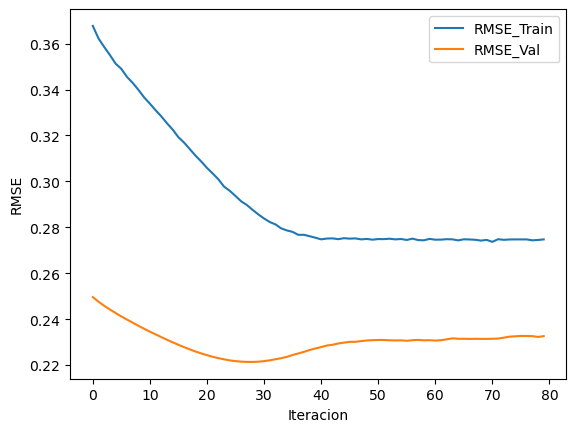

In [32]:
plt.plot(historia.history['loss'],label='RMSE_Train')
plt.plot(historia.history['val_loss'],label='RMSE_Val')
plt.xlabel('Iteracion')
plt.ylabel('RMSE')
plt.legend();

La pérdida se reduce progresivamente en ambos casos a medida que aumentan las iteraciones  
El nivel de pérdida en la iteración final es diferente en ambos casos.  
No se observa Overfitting  
El finetunning del modelo lo hacemos modificando el INPUT_LENGHT y el BATCH_SIZE

**Desempeño del Modelo**

Ahora, verificaremos el desempeño del modelo usando el set de datos que hasta el momento no hemos presentado a la Red: el set de prueba.

In [33]:
rmse_tr = modelo.evaluate(x=x_tr_s, y=y_tr_s, verbose=0)
rmse_vl = modelo.evaluate(x=x_vl_s, y=y_vl_s, verbose=0)
rmse_ts = modelo.evaluate(x=x_ts_s, y=y_ts_s, verbose=0)

In [34]:
print('Comparativo desempeños:')
print(f'  RMSE train:\t {rmse_tr:.3f}')
print(f'  RMSE val:\t {rmse_vl:.3f}')
print(f'  RMSE test:\t {rmse_ts:.3f}')

Comparativo desempeños:
  RMSE train:	 0.273
  RMSE val:	 0.233
  RMSE test:	 0.178


Los RMSEs obtenidos son comparables el modelo generaliza bastante bien (genera predicciones adecuadas sobre un set de datos que no había visto previamente)

**Predicciones (forecasting) con el modelo entrenado**

In [35]:
def predecir(x, model, scaler):
    # Calcular predicción escalada en el rango de -1 a 1
    y_pred_s = model.predict(x,verbose=0)

    # Llevar la predicción a la escala original
    y_pred = scaler.inverse_transform(y_pred_s)

    return y_pred.flatten()

In [36]:
y_ts_pred = predecir(x_ts_s, modelo, scaler)

In [37]:
print(y_ts_pred) 

[35.029694 35.13704  35.052074 34.87716  35.020786 35.029972 35.23986
 35.336166 35.24352  35.48772  35.594353 35.564976 35.251293 35.318413
 35.16408  35.188484 35.3088   35.308807 35.176243 35.356144 35.452766
 34.98158  35.15724  35.12612  35.004105 35.054226 34.76225  35.01776
 35.03197  34.810802 34.84171  34.869965 34.758354 34.486294 34.49314
 34.31278  34.458572 34.46614  34.31295  34.20913  34.248646 34.150738
 34.45468  34.53232  34.516705 34.05186  34.104828 33.930634 33.954975
 34.162403 34.341034 34.20075  34.39667  34.41574  34.959816 35.171345
 35.2533   35.22734  35.441303 35.492733 35.327103 35.54559  35.582443
 35.681744 35.858658 35.825607 35.890102 36.057243 36.054268 35.890972
 36.000935 35.88069  35.779816 35.90123  35.860023]


In [41]:
data = {'y_ts_pred': y_ts_pred}
df = pd.DataFrame(data)
# Luego, exportas el DataFrame a un archivo Excel
df.to_excel('output_TAD.xlsx', index=False)

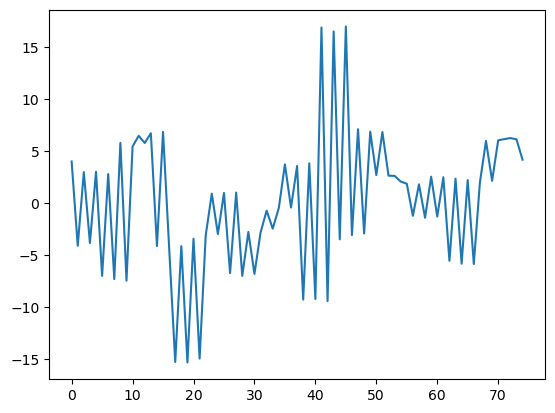

In [38]:
N = len(y_ts_pred)    # Número de predicciones (tamaño del set de prueba)
ndato = np.linspace(1,N,N)

# Cálculo de errores simples
errores = y_ts.flatten()-y_ts_pred
plt.plot(errores);

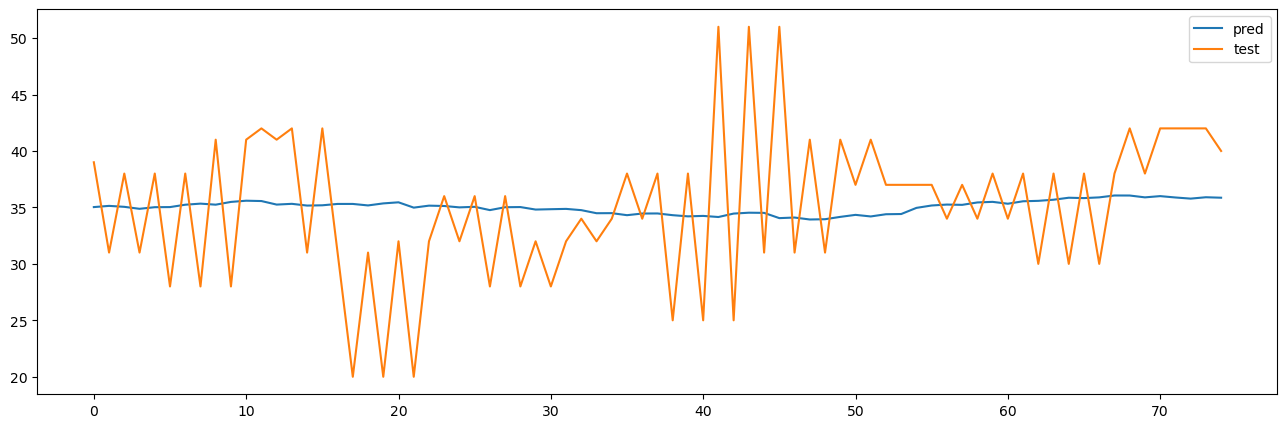

In [39]:
fig, ax = plt.subplots(figsize=(16,5))
ax.plot(y_ts_pred,label="pred")
ax.plot(y_ts.flatten(),label="test")
plt.legend();

**3. Calcular RMSE**

In [40]:
diff_cuad = np.square(y_ts.flatten()-y_ts_pred) 
proms = np.mean(diff_cuad, axis=0) 
rmse = np.sqrt(proms) 
print(rmse)

6.423328582131837
